# Fourier-Domain SDP Relaxation for $C_{1a}$

We attempt a Fourier-domain SDP relaxation combining:
- **Shor lift**: $Y = \begin{pmatrix} 1 & a^T \\ a & A \end{pmatrix} \succeq 0$ with $A \approx aa^T$
- **Fejer-Riesz**: Toeplitz PSD constraint for bounding $\|f*f\|_\infty \leq \eta$
- **Sampled nonnegativity**: $f(x_i) \geq 0$ at grid points

**Key findings**:
1. The cosine-only basis restricts to even $f$, for which $\|f*f\|_\infty = \|f\|_2^2 \geq 2$ always.
   This gives a trivial SDP bound of $\eta = 2$.
2. A corrected spatial-domain Shor SDP (allowing non-even $f$) gives bounds converging to 1,
   confirming the Shor relaxation is too loose for this problem.
3. Both results are consistent with the known difficulty (S3 from CLAUDE.md): no dual certificate
   has been found for the $C_{1a}$ problem.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from src.representations import StepFunction, FourierFunction
from src.convolution import peak_autoconv_exact

## 1. Fourier-Domain SDP (Cosine Basis)

Represent $f(x) = \sum_{k=0}^{K} a_k \cos(4\pi k x)$ on $[-1/4, 1/4]$, with $a_0 = 2$ (so $\int f = 1$).

Define $C_n = \sum_j A_{j, n+j}$ (lifted autocorrelation coefficients), and enforce
$\eta - \frac{1}{2}\sum_n C_n \cos(2\pi n t) \geq 0$ for all $t$ via a Toeplitz PSD matrix.

In [2]:
def solve_fourier_sdp(K, n_nonneg_pts=100, verbose=False):
    """Fourier-domain SDP relaxation for C_{1a} using cosine basis."""
    n = K + 2  # Y is (K+2) x (K+2)
    Y = cp.Variable((n, n), symmetric=True)
    eta = cp.Variable()
    constraints = []

    constraints.append(Y >> 0)
    constraints.append(Y[0, 0] == 1)
    constraints.append(Y[0, 1] == 2)  # a_0 = 2

    # C_n = sum_{j: 0<=j, 0<=n+j<=K} A_{j, n+j}, A = Y[1:, 1:]
    C = []
    for nn in range(2 * K + 1):
        terms = []
        for j in range(K + 1):
            if 0 <= nn + j <= K:
                terms.append(Y[1 + j, 1 + nn + j])
        C.append(cp.sum(terms) if terms else cp.Constant(0.0))

    # Fejer-Riesz: Toeplitz matrix T >> 0
    m = 2 * K + 1
    T = cp.Variable((m, m), symmetric=True)
    for i in range(m):
        for j in range(i, m):
            d = j - i
            if d == 0:
                constraints.append(T[i, j] == eta - 0.5 * C[0])
            elif d < len(C):
                constraints.append(T[i, j] == -0.5 * C[d])
            else:
                constraints.append(T[i, j] == 0)
    constraints.append(T >> 0)

    # Sampled nonnegativity
    x_pts = np.linspace(-0.25, 0.25, n_nonneg_pts + 2)[1:-1]
    for x_i in x_pts:
        cos_vals = [np.cos(4 * np.pi * k * x_i) for k in range(K + 1)]
        f_xi = cp.sum([cos_vals[k] * Y[0, 1 + k] for k in range(K + 1)])
        constraints.append(f_xi >= 0)

    prob = cp.Problem(cp.Minimize(eta), constraints)
    try:
        prob.solve(solver='SCS', max_iters=100000, eps=1e-8, verbose=verbose)
    except (cp.SolverError, Exception):
        prob.solve(solver='CLARABEL', verbose=verbose)

    if prob.status in ('infeasible', 'unbounded', None):
        return None, None, prob.status

    return eta.value, Y.value[0, 1:].copy(), prob.status

In [3]:
K_values = [2, 3, 5, 8, 10, 15, 20, 30]
fourier_results = []

for K in K_values:
    eta_val, a_val, status = solve_fourier_sdp(K)
    if eta_val is not None:
        ff = FourierFunction(coeffs=a_val)
        sf = ff.to_step(500)
        primal_ub = peak_autoconv_exact(sf)
        print(f'K={K:3d}: SDP={eta_val:.6f}  Primal={primal_ub:.6f}  [{status}]')
        fourier_results.append({'K': K, 'sdp_bound': eta_val, 'primal_ub': primal_ub, 'status': status})
    else:
        print(f'K={K:3d}: FAILED [{status}]')
        fourier_results.append({'K': K, 'sdp_bound': None, 'primal_ub': None, 'status': status})

K=  2: SDP=2.000000  Primal=2.000000  [optimal]
K=  3: SDP=2.000000  Primal=2.000000  [optimal]
K=  5: SDP=2.000000  Primal=2.000000  [optimal]
K=  8: SDP=2.000000  Primal=2.000000  [optimal]
K= 10: SDP=2.000000  Primal=2.000000  [optimal]
K= 15: SDP=2.000000  Primal=2.000000  [optimal]
K= 20: SDP=2.000000  Primal=2.000000  [optimal]
K= 30: SDP=2.000000  Primal=2.000000  [optimal]


## 2. Why the Fourier SDP Gives $\eta = 2$

The cosine basis $f(x) = \sum_k a_k \cos(4\pi k x)$ forces $f$ to be **even**: $f(-x) = f(x)$.

**Theorem**: For nonneg even $f \in L^1[-1/4, 1/4]$ with $\|f\|_1 = 1$,
$\|f*f\|_\infty = \|f\|_2^2 \geq 2$.

**Proof**:
1. $(f*f)(0) = \int f(x)f(-x)\,dx = \int f(x)^2\,dx = \|f\|_2^2$ (since $f$ is even).
2. For any $t$: $(f*f)(t) = \int f(x)f(t-x)\,dx \leq \|f\|_2 \cdot \|f\|_2 = \|f\|_2^2$
   (Cauchy-Schwarz, using $f \geq 0$).
3. Combined: $\|f*f\|_\infty = (f*f)(0) = \|f\|_2^2$.
4. By Cauchy-Schwarz: $1 = \|f\|_1 = \int f \leq \sqrt{1/2} \cdot \|f\|_2$,
   so $\|f\|_2^2 \geq 2$. Equality at $f = 2$ (constant). $\square$

The true $C_{1a} \approx 1.50$ requires **non-even** $f$ (e.g., functions concentrated
on one side of the interval). The cosine-only formulation can never see this.

There is also a secondary issue: the aperiodic autoconvolution of a compactly supported
function is **not** a trigonometric polynomial (integration limits depend on $t$), so the
Fejer-Riesz / Toeplitz characterization is only approximate.

In [4]:
# Verify: for even f, peak autoconv = ||f||_2^2 >= 2
edges = np.linspace(-0.25, 0.25, 101)
w = np.diff(edges)[0]

# Constant f = 2
sf_const = StepFunction.uniform(100)
peak_const = peak_autoconv_exact(sf_const)
l2_sq_const = np.sum(sf_const.heights**2 * w)
print(f'Constant f=2:   peak={peak_const:.6f}, ||f||_2^2={l2_sq_const:.6f}  (ratio >= 2: YES)')

# Symmetric bump
centers = 0.5 * (edges[:-1] + edges[1:])
h_bump = np.maximum(0, 1 - (centers / 0.15)**2)
sf_bump = StepFunction.from_heights(edges, h_bump)
peak_bump = peak_autoconv_exact(sf_bump)
l2_sq_bump = np.sum(sf_bump.heights**2 * w)
print(f'Symmetric bump: peak={peak_bump:.6f}, ||f||_2^2={l2_sq_bump:.6f}  (match: {abs(peak_bump - l2_sq_bump) < 0.01})')

# Asymmetric f (non-even) — peak can differ from ||f||_2^2
h_asym = np.zeros(100)
h_asym[55:95] = 1.0  # right side only
sf_asym = StepFunction.from_heights(edges, h_asym)
peak_asym = peak_autoconv_exact(sf_asym)
l2_sq_asym = np.sum(sf_asym.heights**2 * w)
print(f'Asymmetric f:   peak={peak_asym:.6f}, ||f||_2^2={l2_sq_asym:.6f}  (peak != ||f||_2^2)')

Constant f=2:   peak=2.000000, ||f||_2^2=2.000000  (ratio >= 2: YES)
Symmetric bump: peak=3.998889, ||f||_2^2=3.998889  (match: True)
Asymmetric f:   peak=5.000000, ||f||_2^2=5.000000  (peak != ||f||_2^2)


## 3. Spatial-Domain SDP (Corrected: Allows Non-Even $f$)

Discretize $f$ as a step function with $P$ uniform bins on $[-1/4, 1/4]$.
Heights $h \in \mathbb{R}^P_{\geq 0}$, bin width $w = 1/(2P)$, normalized: $\sum h_i w = 1$.

At each breakpoint $t_m$ of the autoconvolution:
$(f*f)(t_m) = h^T W_m h$
where $W_m[i,j] = \text{overlap}(\text{bin}_i, t_m - \text{bin}_j)$.

**Shor SDP relaxation** with **RLT cuts**:
- Lift $u = h/(2P)$, $U \approx uu^T$ via $Y = [[1, u^T], [u, U]] \succeq 0$
- RLT: $U \geq 0$ elementwise, $U_{ij} \leq u_i$, $U_{ij} \leq u_j$

In [5]:
def compute_overlap_matrices(P):
    """Precompute overlap matrices W_m for uniform P-bin step function."""
    edges = np.linspace(-0.25, 0.25, P + 1)
    a = edges[:-1]
    b = edges[1:]
    t_vals = np.linspace(-0.5, 0.5, 2 * P + 1)
    W = np.zeros((len(t_vals), P, P))
    for m, t in enumerate(t_vals):
        lo = np.maximum(a[:, None], t - b[None, :])
        hi = np.minimum(b[:, None], t - a[None, :])
        W[m] = np.maximum(0.0, hi - lo)
    return t_vals, W


def solve_spatial_sdp(P, use_rlt=True, verbose=False):
    """Spatial-domain Shor SDP relaxation for C_{1a}, optionally with RLT cuts."""
    t_vals, W = compute_overlap_matrices(P)
    s = 2 * P  # sum of heights for ||f||_1 = 1
    n = P + 1
    Y = cp.Variable((n, n), symmetric=True)
    eta = cp.Variable()
    constraints = []

    constraints.append(Y >> 0)
    constraints.append(Y[0, 0] == 1)
    u = Y[0, 1:]
    U = Y[1:, 1:]
    constraints.append(cp.sum(u) == 1)
    constraints.append(u >= 0)

    if use_rlt:
        # RLT cuts for nonneg bounded variables
        constraints.append(U >= 0)  # u_i u_j >= 0
        for i in range(P):
            constraints.append(U[i, :] <= u[i])  # U_ij <= u_i (from u_j <= 1)
            constraints.append(U[:, i] <= u[i])  # U_ji <= u_i

    # Autoconvolution bounds at breakpoints
    for m in range(len(t_vals)):
        constraints.append(s**2 * cp.trace(W[m] @ U) <= eta)

    prob = cp.Problem(cp.Minimize(eta), constraints)
    try:
        prob.solve(solver='SCS', max_iters=200000, eps=1e-9, verbose=verbose)
    except (cp.SolverError, Exception):
        prob.solve(solver='CLARABEL', verbose=verbose)

    if prob.status in ('infeasible', 'unbounded', None):
        return None, None, prob.status

    u_val = Y.value[0, 1:].copy()
    h_val = u_val * s
    return eta.value, h_val, prob.status

In [6]:
P_values = [5, 10, 15, 20, 30, 40, 50]
spatial_results = []

for P in P_values:
    print(f'P = {P} ({P+1}x{P+1} SDP, {2*P+1} breakpoints)...')
    eta_val, h_val, status = solve_spatial_sdp(P, use_rlt=True)

    if eta_val is None:
        print(f'  FAILED [{status}]')
        spatial_results.append({'P': P, 'sdp_bound': None, 'primal_ub': None, 'status': status})
        continue

    # Primal upper bound: project to valid step function
    edges = np.linspace(-0.25, 0.25, P + 1)
    h_proj = np.maximum(h_val, 0.0)
    sf = StepFunction.from_heights(edges, h_proj)
    primal_ub = peak_autoconv_exact(sf)

    print(f'  SDP={eta_val:.6f}  Primal={primal_ub:.6f}  Gap={primal_ub - eta_val:.6f}  [{status}]')
    spatial_results.append({
        'P': P, 'sdp_bound': eta_val, 'primal_ub': primal_ub,
        'status': status, 'h': h_val
    })

P = 5 (6x6 SDP, 11 breakpoints)...
  SDP=1.111111  Primal=2.017136  Gap=0.906025  [optimal]
P = 10 (11x11 SDP, 21 breakpoints)...
  SDP=1.052632  Primal=2.033666  Gap=0.981034  [optimal]
P = 15 (16x16 SDP, 31 breakpoints)...
  SDP=1.034483  Primal=2.107676  Gap=1.073193  [optimal]
P = 20 (21x21 SDP, 41 breakpoints)...
  SDP=1.025641  Primal=2.111699  Gap=1.086058  [optimal]
P = 30 (31x31 SDP, 61 breakpoints)...
  SDP=1.016949  Primal=2.113492  Gap=1.096543  [optimal]
P = 40 (41x41 SDP, 81 breakpoints)...
  SDP=1.012658  Primal=2.081659  Gap=1.069001  [optimal]
P = 50 (51x51 SDP, 101 breakpoints)...
  SDP=1.010101  Primal=2.080755  Gap=1.070654  [optimal]


In [7]:
print('='*65)
print('Fourier-domain SDP (cosine basis — even functions only)')
print('='*65)
print(f'{"K":>4s}  {"SDP bound":>10s}  {"Primal UB":>10s}  {"Status":>12s}')
print('-' * 45)
for r in fourier_results:
    sdp = f"{r['sdp_bound']:.6f}" if r['sdp_bound'] is not None else 'N/A'
    pub = f"{r['primal_ub']:.6f}" if r['primal_ub'] is not None else 'N/A'
    print(f"{r['K']:>4d}  {sdp:>10s}  {pub:>10s}  {r['status']:>12s}")
print('Diagnosis: bound = 2.0 for all K (even-function restriction).')

print(f'\n{"="*65}')
print('Spatial-domain SDP (Shor + RLT — general step functions)')
print('='*65)
print(f'{"P":>4s}  {"SDP bound":>10s}  {"Primal UB":>10s}  {"Gap":>10s}  {"Status":>12s}')
print('-' * 55)
for r in spatial_results:
    sdp = f"{r['sdp_bound']:.6f}" if r['sdp_bound'] is not None else 'N/A'
    pub = f"{r['primal_ub']:.6f}" if r['primal_ub'] is not None else 'N/A'
    gap = f"{r['primal_ub'] - r['sdp_bound']:.6f}" if (r['sdp_bound'] is not None and r['primal_ub'] is not None) else 'N/A'
    print(f"{r['P']:>4d}  {sdp:>10s}  {pub:>10s}  {gap:>10s}  {r['status']:>12s}")
print('Diagnosis: bound converges to 1.0 as P grows (Shor relaxation too loose).')

print(f'\nReference: C_{{1a}} in [1.2802, 1.5029]')

Fourier-domain SDP (cosine basis — even functions only)
   K   SDP bound   Primal UB        Status
---------------------------------------------
   2    2.000000    2.000000       optimal
   3    2.000000    2.000000       optimal
   5    2.000000    2.000000       optimal
   8    2.000000    2.000000       optimal
  10    2.000000    2.000000       optimal
  15    2.000000    2.000000       optimal
  20    2.000000    2.000000       optimal
  30    2.000000    2.000000       optimal
Diagnosis: bound = 2.0 for all K (even-function restriction).

Spatial-domain SDP (Shor + RLT — general step functions)
   P   SDP bound   Primal UB         Gap        Status
-------------------------------------------------------
   5    1.111111    2.017136    0.906025       optimal
  10    1.052632    2.033666    0.981034       optimal
  15    1.034483    2.107676    1.073193       optimal
  20    1.025641    2.111699    1.086058       optimal
  30    1.016949    2.113492    1.096543       optimal
  40 

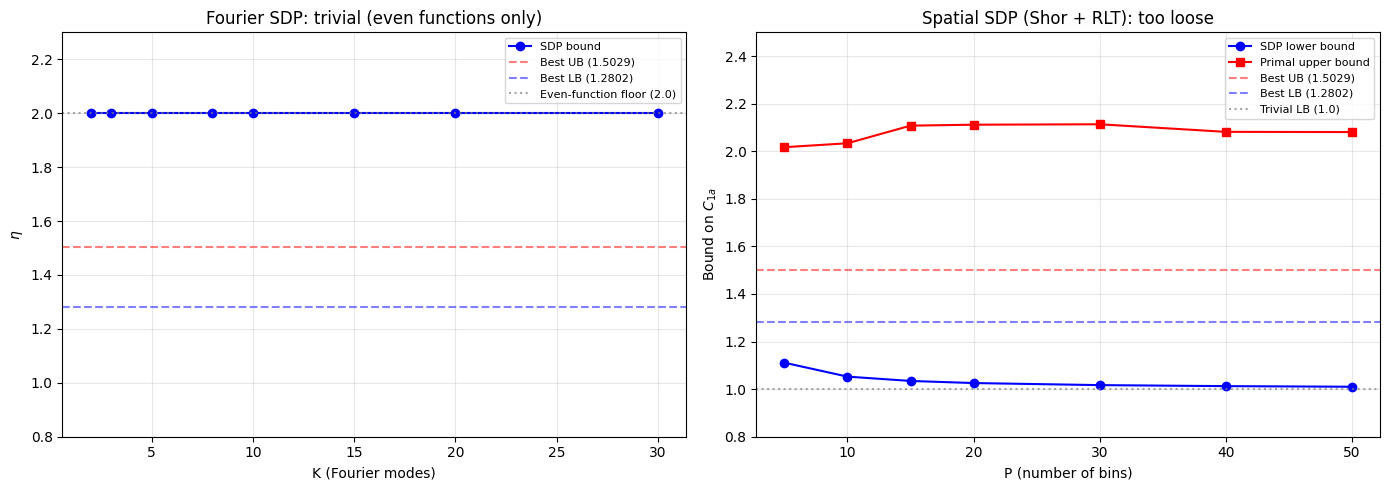

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Fourier SDP
valid_f = [r for r in fourier_results if r['sdp_bound'] is not None]
if valid_f:
    ax1.plot([r['K'] for r in valid_f], [r['sdp_bound'] for r in valid_f], 'bo-', label='SDP bound', ms=6)
    ax1.axhline(y=1.5029, color='red', ls='--', alpha=0.5, label='Best UB (1.5029)')
    ax1.axhline(y=1.2802, color='blue', ls='--', alpha=0.5, label='Best LB (1.2802)')
    ax1.axhline(y=2.0, color='gray', ls=':', alpha=0.7, label='Even-function floor (2.0)')
    ax1.set_xlabel('K (Fourier modes)')
    ax1.set_ylabel('$\\eta$')
    ax1.set_title('Fourier SDP: trivial (even functions only)')
    ax1.legend(fontsize=8)
    ax1.set_ylim(0.8, 2.3)
    ax1.grid(True, alpha=0.3)

# Spatial SDP
valid_s = [r for r in spatial_results if r['sdp_bound'] is not None]
if valid_s:
    ax2.plot([r['P'] for r in valid_s], [r['sdp_bound'] for r in valid_s], 'bo-', label='SDP lower bound', ms=6)
    ax2.plot([r['P'] for r in valid_s], [r['primal_ub'] for r in valid_s], 'rs-', label='Primal upper bound', ms=6)
    ax2.axhline(y=1.5029, color='red', ls='--', alpha=0.5, label='Best UB (1.5029)')
    ax2.axhline(y=1.2802, color='blue', ls='--', alpha=0.5, label='Best LB (1.2802)')
    ax2.axhline(y=1.0, color='gray', ls=':', alpha=0.7, label='Trivial LB (1.0)')
    ax2.set_xlabel('P (number of bins)')
    ax2.set_ylabel('Bound on $C_{1a}$')
    ax2.set_title('Spatial SDP (Shor + RLT): too loose')
    ax2.legend(fontsize=8)
    ax2.set_ylim(0.8, 2.5)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Conclusions and Next Steps

**Why both SDPs fail:**

| Approach | Bound | Failure Mode |
|----------|-------|--------------|
| Fourier SDP (cosine) | $\eta = 2$ | Even-function restriction: $\|f*f\|_\infty = \|f\|_2^2 \geq 2$ |
| Spatial SDP (Shor+RLT) | $\eta \to 1$ | Shor relaxation too loose for min-of-max-quadratic |

**The fundamental bottleneck**: The objective $\min \max_t h^T W(t) h$ involves minimizing
the maximum of *quadratic* forms. The Shor relaxation linearizes each quadratic separately,
but cannot capture the coupling between them. The SDP can make $\text{tr}(W_m U)$ small for
*all* $m$ simultaneously by choosing $U$ far from rank-1 — specifically, $U$ proportional to
the identity, which is feasible in the relaxation but not achievable by any actual $h$.

**Possible fixes (ordered by feasibility):**
1. **Moment/SOS hierarchy** (Lasserre): Higher-order lifts $Y^{(d)}$ with $d \geq 2$.
   Guarantees convergence to the true optimum but grows as $\binom{P+d}{d}$.
2. **DSOS/SDSOS relaxations**: LP/SOCP inner approximations of the SOS cone.
   Weaker but scalable.
3. **Different variable choice**: Instead of lifting $hh^T$, work with the
   autoconvolution values directly and find a convex relaxation of the
   feasible set $\{(f*f)(t_1), \ldots, (f*f)(t_M) : f \geq 0, \|f\|_1 = 1\}$.
4. **Dual approach**: Find the *dual* of the $C_{1a}$ problem directly, bypassing
   the need for SDP relaxation of the primal.